# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width='500px'>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# Magic Commands
%matplotlib inline
%config inlineBackend.figure_format = 'retina'

# Import here
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Baskets full of flowers for my valentines day
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


In [253]:
# TODO: Define your transforms for the training, validation, and testing sets
def data_loader(data_dir, train_dir, valid_dir, test_dir):
    # I'm just going to put my hands in the training flower basket and shuffle, cut and skew my flowers
    train_transforms = transforms.Compose([transforms.RandomRotation(30), 
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

    test_valid_transforms = transforms.Compose([transforms.Resize(255),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

    
    # TODO: Load the datasets with ImageFolder
    train_data = datasets.ImageFolder(train_dir, transform= train_transforms)
    test_data = datasets.ImageFolder(test_dir, transform= test_valid_transforms)
    valid_data = datasets.ImageFolder(valid_dir, transform= test_valid_transforms)

    # TODO: Using the image datasets and the trainforms, define the dataloaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
    return train_data, test_data, valid_data, train_loader, test_loader, valid_loader

In [254]:
train_data, test_data, valid_data, train_loader, test_loader, valid_loader =  data_loader(data_dir, train_dir, 
                                                                                          valid_dir, test_dir)

In [5]:
# function to show images - I will need this to see if my images have been imported and transformed correctly

def show_images(image, subplot=None, title=None, normalize=True):
    """Imshow for Tensor."""
    
    plt.subplot(1,3, subplot)
    
    # Converting image to a numpy array and reshaping the array via a transpose to allow for matrix multiplication
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean # Reversing the normalisation process so that images can be plotted in real pixels
        image = np.clip(image, 0, 1) # Values outside of [0, 1] interavl become either 0 or 1 
        
    plt.title(title)  
    plt.imshow(image)
    
    

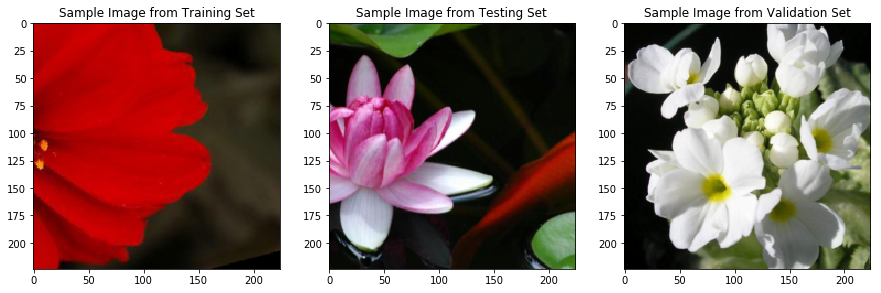

In [7]:
# Grabbing a sample image from image generators
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))
valid_images, valid_labels = next(iter(valid_loader))

# Plotting images
plt.figure(figsize=(15,5))
show_images(train_images[0], subplot=1, title = "Sample Image from Training Set");

show_images(test_images[0], subplot=2,  title = "Sample Image from Testing Set");

show_images(valid_images[0],subplot =3,  title = "Sample Image from Validation Set");


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
        

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [9]:
# Attempt 1 - tried transfer learning using VGG11. VGG11 features layer output is massive! 25K Nodes!!!!!! 
# If I wanted to save the model just for the first layer I needed 800mb!
# Model Performance after 10 epochs was ridiculous 20% accuracy on training and 3% accuracy on testing set!!!!

# Attempt 2 - Densenet112 with four layers 1024, 500, 300 and 102 - Acheieved accuracy of 85% in 30 epochs
# 30 Mins to train

model = models.densenet121(pretrained= True)


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 83427743.94it/s]


In [10]:
# TODO: Freezing the model parameters
# Let's freeze the model parameters as it is already trained. This will freeze the classifier parameters too
# but that's ok as I will be replacing the VGG classifier with my own which will have unfrozen parameters.

for param in model.parameters():
    param.requires_grad= False
    
    

In [11]:
# TODO: Build your network
# Defining classifier architecture to replace the Densenet classifier

class Classifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer, drop_p=0.2):
        ''' Builds a feedforward network with hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.fc1 = nn.Linear(input_size, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, output_size)
        
        # Defining a dropout with probability of drop_p to avoid overfitting
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # Flatten image now so we don't have to later
        x= x.view(x.shape[0], -1)
        
        # Activation Functions
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x


In [12]:
# Replacing the pre-trained model classifier with my own. The previous classifier parameters were frozen.
# Mine aren't so now if I train the network, only parameters of my classifier will be updated not the features layer.
model.classifier = Classifier(1024, 102, 1000)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()
model.to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

In [14]:
def validation(model, data_loader, criterion, device):
    ''' Validates the predictions of the network.

        Arguments
        ---------
        model: dictionary, neural network model
        data_loader: a data generator that can provide a batch of data for validation
        criterion: Torch function, Is used to calculate the error loss
        device: string that specifies what hardware the validation should be run on
        
        Outputs
        ---------
        test_loss: Average loss per batch
        accuracy: Average accuracy in percentage per batch

    '''
    model.eval()
    test_loss = 0
    accuracy = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        valid_logits = model.forward(images)
        test_loss += criterion(valid_logits, labels)
        ps = torch.exp(valid_logits)
        top_p, top_class = ps.topk(1, dim =1)
        equality = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equality.type(torch.FloatTensor))
        
    return test_loss, accuracy

In [15]:
# TODO: Train your network
# Time for some action - Where are my GPUs?
def train(model, device = device, train_loader = train_loader, valid_loader = valid_loader, 
          criterion = criterion, optimizer = optimizer, epochs=10):
    ''' Trains a neural network.

        Arguments
        ---------
        model: Un-trained Model
        train_loader: a data generator that can provide a batch of data for training the model
        valid_loader: a data generator that can provide a batch of data for validating the model
        criterion: Torch Function, Is used to calculate the error loss
        device: string that specifies what hardware the validation should be run on
        optimizer: Torch Module, Optimises the model weights per epoch
        
        Outputs
        ---------
        model: Trained Model
        training_losses: A list of average training losses in percentage of the batch per epoch
        validation_losses: A list of average validation losses of the batch per epoch
        validation_accuracies: A list of average accuracies in percentage of the batch per epoch

    '''
    training_losses , validation_losses, validation_accuracies = [], [], []

    for e in range(epochs):
        training_loss = 0
        model.train()
        # Perform a training pass for all images
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            train_logits = model(images)
            loss = criterion(train_logits, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        # Perform a validation pass for all images
        else:

            with torch.no_grad():
                validation_loss, validation_accuracy = validation(model, valid_loader, criterion, device)
                training_losses.append(training_loss/len(train_loader))
                validation_losses.append(validation_loss/len(valid_loader))
                validation_accuracies.append(validation_accuracy/len(valid_loader))

                print(f"Device = {device}", "Epoch {}/{}.. ".format(e+1, epochs),
                     "Training Loss: {:.3f}.. ".format(training_loss/len(train_loader)),
                     "Validation Loss: {:.3f}.. ".format(validation_loss/len(valid_loader)),
                     "Validation Accuracy: {:.3f}".format(validation_accuracy/len(valid_loader)))

                model.train()
                
    return model, training_losses, validation_losses, validation_accuracies
            

In [72]:
model, training_losses, validation_losses, validation_accuracies = train(model)

Device = cuda:0 Epoch 1/10..  Training Loss: 2.744..  Validation Loss: 1.022..  Validation Accuracy: 0.789
Device = cuda:0 Epoch 2/10..  Training Loss: 1.042..  Validation Loss: 0.505..  Validation Accuracy: 0.881
Device = cuda:0 Epoch 3/10..  Training Loss: 0.727..  Validation Loss: 0.408..  Validation Accuracy: 0.900
Device = cuda:0 Epoch 4/10..  Training Loss: 0.633..  Validation Loss: 0.320..  Validation Accuracy: 0.911
Device = cuda:0 Epoch 5/10..  Training Loss: 0.542..  Validation Loss: 0.292..  Validation Accuracy: 0.923
Device = cuda:0 Epoch 6/10..  Training Loss: 0.478..  Validation Loss: 0.255..  Validation Accuracy: 0.930
Device = cuda:0 Epoch 7/10..  Training Loss: 0.463..  Validation Loss: 0.247..  Validation Accuracy: 0.937
Device = cuda:0 Epoch 8/10..  Training Loss: 0.456..  Validation Loss: 0.271..  Validation Accuracy: 0.927
Device = cuda:0 Epoch 9/10..  Training Loss: 0.422..  Validation Loss: 0.251..  Validation Accuracy: 0.932
Device = cuda:0 Epoch 10/10..  Traini

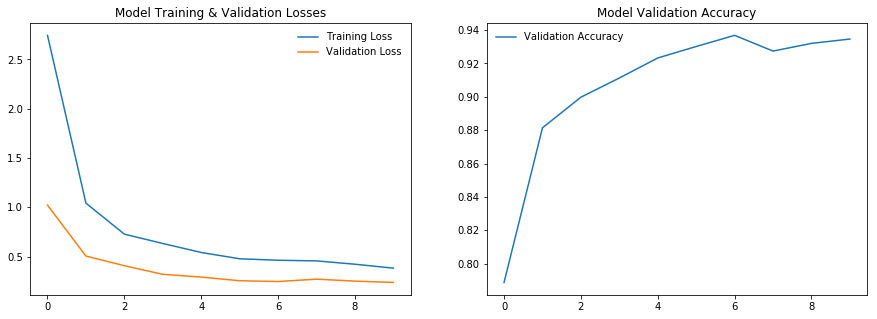

In [73]:
# Plotting Model Performance
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.title("Model Training & Validation Losses")
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend(frameon= False);

plt.subplot(1,2,2)
plt.title("Model Validation Accuracy")
plt.plot(validation_accuracies, label="Validation Accuracy")
plt.legend(frameon= False);


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [74]:
# TODO: Do validation on the test set
with torch.no_grad():
    testing_loss, testing_accuracy = validation(model, test_loader, criterion, device)
    print("Testing Loss: {:.3f}.. ".format(testing_loss/len(test_loader)),
          "Testing Accuracy: {:.3f}".format(testing_accuracy/len(test_loader)))

    

Testing Loss: 0.223..  Testing Accuracy: 0.943


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [75]:
# Print model's state_dict
print("Classifier's state_dict:")
for param_tensor in model.classifier.state_dict():
    print(param_tensor, "\t", model.classifier.state_dict()[param_tensor].size())
    
    
    

Classifier's state_dict:
fc1.weight 	 torch.Size([1000, 1024])
fc1.bias 	 torch.Size([1000])
fc2.weight 	 torch.Size([102, 1000])
fc2.bias 	 torch.Size([102])


In [82]:
# TODO: Save the checkpoint 

def save_model(model, data):
    
    ''' Saves the model checkpoint into a tph file
    '''
    model.class_to_idx = data.class_to_idx

    checkpoint = {"feature_extractor": "Densenet121",
                  "input_size": 1024,
                 "output_size": 102,
                 "hidden_layer": 1000,
                  "class_to_idx": data.class_to_idx,
                  "epochs": 10,
                  "dropout": 0.2,
                  "criterion": nn.NLLLoss(),
                    ## This makes it much easier to plug in the classifier to Alexnet if not rebuilding
                  "state_dict": model.state_dict(),
                 "optimiser_state_dict": optimizer.state_dict()}
    
    torch.save(checkpoint, "checkpoint.tph")
    
    return "Model Saved!"


In [87]:
save_model(model, train_data)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


'Model Saved!'

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [306]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def checkpoint_loader(filepath):
    ''' Constructs the fully trained model from a saved checkpoint.
    '''
    model = models.densenet121(pretrained= True)
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    model.classifier = Classifier(checkpoint['input_size'], 
                                  checkpoint['output_size'], 
                                  checkpoint['hidden_layer'],
                                 checkpoint['dropout'])
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint["class_to_idx"]
    
    return model

In [307]:
# Loading the model
model = checkpoint_loader("checkpoint.tph")


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [308]:
# TODO: Check that model is loaded successfully by running a test
testing_losses, testing_accuracies = [], []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    testing_loss, testing_accuracy = validation(model, test_loader, criterion, device)
    print("Testing Loss: {:.3f}.. ".format(testing_loss/len(test_loader)),
          "Testing Accuracy: {:.3f}".format(testing_accuracy/len(test_loader)))


    

KeyboardInterrupt: 

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [37]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image)
    
    # Resizes image so shortest side is 256px while keeping aspect ratio (Image.thumbnail)
    pil_image.thumbnail([pil_image.size[0],256])
    
    # Crop out the center of 224x224 portion of the image
    w, h = pil_image.size
    i = int(round((w - 224)/2)) # x coordinate
    j = int(round((h- 224)/2)) # y coordinate
    pil_image = pil_image.crop([i,j, i+224, j+224])  # x-coord, y-coord, x+crop_size coord, y=crop_size coord)
            
    # Normalise color channels to range [0, 1] - Use np.array(pil_image)
    np_image = np.array(pil_image)
    np_image = np_image/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image- mean) / std
    
    # Transpose array to what Pytorch expects using ndarray.tranpose() from (W, H, Color) to (color, h, w)
    np_image = np_image.transpose((2, 0, 1)) 
     
    # Convert to numpy array to torch
    tensor_image = torch.from_numpy(np_image)

    
    return tensor_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [38]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

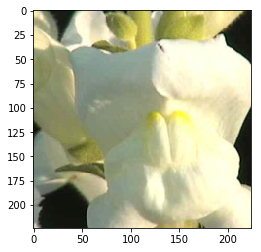

In [40]:
imshow(process_image("flowers/test/11/image_03098.jpg"));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    ps = model.forward(image_path)
    return ps.topk(topk, dim = 1)
    
    
    
    
    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width='300px'>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [116]:
# TODO: Display an image along with the top 5 classes
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze() # Squeeze method removes single-dimensional entries from the shape of an array.

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(3, 224, 224).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    probs, classes = predict(image_path, model)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(top_five_class_names, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

test_images, test_labels = next(iter(test_loader))
img = test_images[0]
img = img.view(1, img.shape[0]*img.shape[1]*img.shape[2])

with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)


view_classify(img.view(3, 224, 224), ps)


torch.Size([1, 150528])
